#### 교수님이 수정하라는 코드  

In [5]:
!pip install torchviz

  Using cached graphviz-0.19.1-py3-none-any.whl (46 kB)
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4150 sha256=8be4752c6900c75671f86d7fcb1b490896d85abb784050af37072cb8e2b1c863
  Stored in directory: c:\users\hyunjin\appdata\local\pip\cache\wheels\04\38\f5\dc4f85c3909051823df49901e72015d2d750bd26b086480ec2
Successfully built torchviz


In [ ]:
#https://lynnshin.tistory.com/54
from torchviz import make_dot 
import torch 
x= torch.zeros(1,1,28,28)
make_dot()


In [4]:
from tensorflow.keras.layers import Embedding, Dense, GRU
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
model = Sequential()

model.add(Embedding(9000, 100 ))
    #2. 은닉층으로 GRU와 hidden units 128
model.add(GRU(128))
    #3. 출력층 Dense레이어, 1 개의 값, 시그모이드 (0~1사이의 값)
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 100)         900000    
                                                                 
 gru_1 (GRU)                 (None, 128)               88320     
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 988,449
Trainable params: 988,449
Non-trainable params: 0
_________________________________________________________________


In [8]:
%%writefile MessageClassifier_with_1gram_for_Learning.py
#MessageClassifier_with_1gram_for_Learning.py
from utils import *
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import urllib.request
from collections import Counter
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from konlpy.tag import Mecab
from tensorflow.keras.layers import Embedding, Dense, GRU
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
    
def MessageClassifier_with_1gram_for_Learning(username, prname):
    #0. 파일 읽기 
    if (username == None) & (prname == None):
        input_directory=''
    else:    
        input_directory = "/".join([username, prname])
    ref, input_, output_ = Read_Arg_(username, prname, "MessageClassifier_with_1gram_for_Learning")
    #input_ : 별점있는 리뷰데이터 (학습시킬)
    #output_ : 학습시킨 모델을 저장할 이름 ('~~.h5' 형태로 엑셀에 적어야 놔야함)
    option_dic=option_finder(username, prname, "MessageClassifier_with_1gram_for_Learning")

    
    #1. 메캅설치 확인 (형태소 분석기 어느형태든 상관없음)
    try: 
        mecab = Mecab("C:\mecab\mecab-ko-dic") #자신의 메캅설치 경로 
        print(mecab.morphs('와 이런 것도 상품이라고 차라리 내가 만드는 게 나을 뻔'))
    except :
        print('메캅이 설치되어 있지 않습니다')
    
    #2. 데이터 읽기
    if input_[-3:]=='csv':
        df = pd.read_csv(input_)
    elif input_[-4:]=='xlsx':
        df = pd.read_excel(input_)
    else:
        print('잘못된 인풋파일 형식입니다.')
    
    #3. 3점 제외 후 레이블 만들기 
    df.drop(df.loc[df['score']==' 별표 3개 '].index, inplace=True)
    df['ratings'] =0 #레이팅 컬럼 
    df.loc[(df.score == ' 별표 5개 ') ,'ratings'] = 5 
    df.loc[(df.score == ' 별표 4개 ') ,'ratings'] = 4 
    df.loc[(df.score == ' 별표 2개 ') ,'ratings'] = 2 
    df.loc[(df.score == ' 별표 1개 ') ,'ratings'] = 1 
    
    #4. 긍정은 4,5점-> 1로 레이블링, 부정은 1,2점-> 0으로 레이블링
    df['label'] = np.select([df.ratings > 3], [1], default=0)
    
    #5. 결측치 제거, reviews 열에서 중복인 내용이 있다면 중복 제거
    print('총 샘플의 수 :',len(df))
    print('ratings, contents,label :',df['ratings'].nunique(), df['contents'].nunique(), df['label'].nunique())
    df.drop_duplicates(subset=['contents'], inplace=True) 
    df=df.dropna()
    print('널인 데이터있나? :',df.isnull().values.any())
    
    #6. 훈련데이터 프레임, 테스트 데이터 프레임 분리 
    train_data, test_data = train_test_split(df, test_size = 0.25, random_state = 42)
    print('훈련용 리뷰의 개수 :', len(train_data))
    print('테스트용 리뷰의 개수 :', len(test_data))
    
    #7. 훈련 전에 레이블의 분포를 확인 (너무 비대칭이라면 적절히 샘플링해서 돌려보는 것도..)
    train_data['label'].value_counts().plot(kind = 'bar')

    #8. 데이터프레임 중 mecab.morphs를 활용하여 토큰화한 열 추가 
    stopwords = ['pessriod','도', '는', '다', '의', '가', '이', '은', '한', '에', '하', '고', '을', '를', '인', '듯', '과', '와', '네', '들', '듯', '지', '임', '게']
    train_data['contents'] =train_data['contents'].astype('str')
    train_data['tokenized'] = train_data['contents'].apply(mecab.morphs)
    train_data['tokenized'] = train_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])
    test_data['tokenized'] = test_data['contents'].apply(mecab.morphs)
    test_data['tokenized'] = test_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])

    #9. 리뷰 길이를 고정해서 학습시켜야 하므로 리뷰 전체 길이 분포 확인
    fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
    text_len = train_data[train_data['label']==1]['tokenized'].map(lambda x: len(x))
    ax1.hist(text_len, color='red')
    ax1.set_title('Positive Reviews')
    ax1.set_xlabel('length of samples')
    ax1.set_ylabel('number of samples')
    print('긍정 리뷰의 평균 길이 :', np.mean(text_len))

    text_len = train_data[train_data['label']==0]['tokenized'].map(lambda x: len(x))
    ax2.hist(text_len, color='blue')
    ax2.set_title('Negative Reviews')
    fig.suptitle('Words in texts')
    ax2.set_xlabel('length of samples')
    ax2.set_ylabel('number of samples')
    print('부정 리뷰의 평균 길이 :', np.mean(text_len))
    plt.show()
    
    #10. 훈련 데이터, 테스트 데이터에 각 필요한 토큰화한 값과 레이블만 넣기 
    X_train = train_data['tokenized'].values
    y_train = train_data['label'].values
    X_test= test_data['tokenized'].values
    y_test = test_data['label'].values
    
    
    #11. 몇개의 단어로 토큰화할건지 
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(X_train)
    threshold = 2
    total_cnt = len(tokenizer.word_index) # 단어의 수
    rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
    total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
    rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

    # 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
    for key, value in tokenizer.word_counts.items():
        total_freq = total_freq + value

        # 단어의 등장 빈도수가 threshold보다 작으면
        if(value < threshold):
            rare_cnt = rare_cnt + 1
            rare_freq = rare_freq + value

    print('단어 집합(vocabulary)의 크기 :',total_cnt)
    print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
    print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
    print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)
    
    # 전체 단어 개수 중 빈도수 2이하인 단어 개수는 제거.
    # 0번 패딩 토큰과 1번 OOV 토큰을 고려하여 +2
    # 단어 집합의 크기 결정 후 토크나이저 
    vocab_size = total_cnt - rare_cnt + 2
    print('단어 집합의 크기 :',vocab_size)
    
    #가장 빈도가 높은 vocab_size개의 단어만 선택하도록 Tokenizer 객체를 만듦
    tokenizer = Tokenizer(vocab_size, oov_token = 'OOV') 
    #단어 인덱스를 구축하여 단어들을 벡터화할 수 있게 해줌
    tokenizer.fit_on_texts(X_train)
    X_train = tokenizer.texts_to_sequences(X_train)
    X_test = tokenizer.texts_to_sequences(X_test)
    
    
    print('리뷰의 최대 길이 :',max(len(review) for review in X_train))
    print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
    plt.hist([len(review) for review in X_train], bins=50)
    plt.xlabel('length of samples')
    plt.ylabel('number of samples')
    plt.show()
    
    def below_threshold_len(max_len, nested_list):
        count = 0
        for sentence in nested_list:
            if(len(sentence) <= max_len):
                count = count + 1
        
        print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))
        print('90% 이하라면 위의 리뷰 최대 길이를 참고하여 option_2 설정에서 default length 가 아닌 원하는 숫자로 바꿔주세요.')
    #리뷰 최대길이로 설정 후 패딩 해주기 
    if option_dic['option_2']=='default length':
        max_len = 80
    else :
        max_len = int(option_dic['option_2'])
    below_threshold_len(max_len, X_train)
    X_train = pad_sequences(X_train, maxlen=max_len)
    X_test = pad_sequences(X_test, maxlen=max_len)
    

    #vocab_size : 단어 집합의 크기 
    #max_len : 리뷰 최대 길이 제한 
    #embedding_dim : 100차원으로 실수 벡터를 만들겠다. 
    #hidden_units : 출력의 크기 = 은닉 상태의 뉴런개수 (최종 출력할 값보다 크게하면 됨)
    
    #vocab_size가 너무 크면 embedding 차원을 좀 올려야 정보 손실이 덜 될테니 
    output_dim=100
    if option_dic['option_1']=='default units':
        hidden_units = 100
    else :
        hidden_units = int(option_dic['option_1'])
    
    model = Sequential()

    #1. Embedding layer 를 추가한다 (input_vocab size와 output embedding dimension)
    # Embedding 층은 매개변수
    # 가능한 토큰의 개수(여기서는 vocab_size으로 단어 인덱스 최댓값 + 1입니다)와 임베딩 차원(여기서는 64)입니다
    model.add(Embedding(vocab_size, output_dim ))
    #2. 은닉층으로 GRU와 hidden units 128
    model.add(GRU(hidden_units))
    #3. 출력층 Dense레이어, 1 개의 값, 시그모이드 (0~1사이의 값)
    model.add(Dense(1, activation='sigmoid'))

    mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)

    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
    history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=64, validation_split=0.2)
    
    out_list=output_.split(',')
    #학습한 모델 저장
    model.save(out_list[0])
    
    #토크나이저 저장
    with open(out_list[1], 'wb') as handle:
        pickle.dump(tokenizer, handle)
if __name__=='__main__':
    MessageClassifier_with_1gram_for_Learning(None,None)

Overwriting MessageClassifier_with_1gram_for_Learning.py


['와', '이런', '것', '도', '상품', '이', '라고', '차라리', '내', '가', '만드', '는', '게', '나을', '뻔']
총 샘플의 수 : 83699
ratings, contents,label : 5 67707 2
널인 데이터있나? : False
훈련용 리뷰의 개수 : 50780
테스트용 리뷰의 개수 : 16927
긍정 리뷰의 평균 길이 : 9.608294216632716
부정 리뷰의 평균 길이 : 12.720263532763532


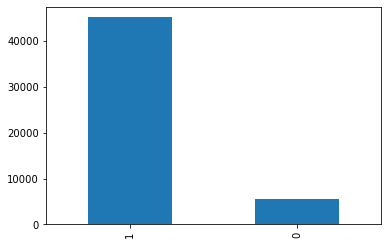

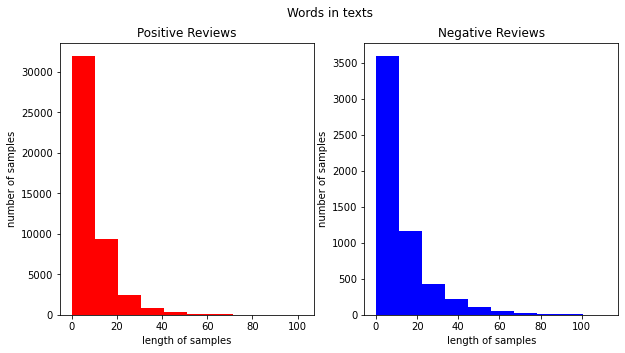

단어 집합(vocabulary)의 크기 : 17292
등장 빈도가 1번 이하인 희귀 단어의 수: 8137
단어 집합에서 희귀 단어의 비율: 47.05644228544992
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 1.6100564716869876
단어 집합의 크기 : 9157
리뷰의 최대 길이 : 112
리뷰의 평균 길이 : 9.952461599054747


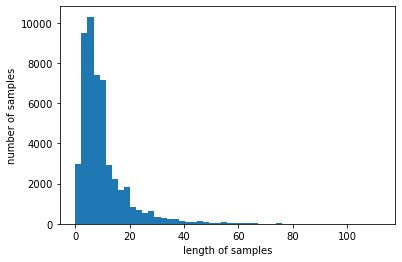

전체 샘플 중 길이가 80 이하인 샘플의 비율: 99.91532099251674
90% 이하라면 위의 리뷰 최대 길이를 참고하여 option_2 설정에서 default length 가 아닌 원하는 숫자로 바꿔주세요.
Epoch 1/15
635/635 [==============================] - ETA: 0s - loss: 0.2132 - acc: 0.9185
Epoch 1: val_acc improved from -inf to 0.93472, saving model to best_model.h5
635/635 [==============================] - 27s 40ms/step - loss: 0.2132 - acc: 0.9185 - val_loss: 0.1813 - val_acc: 0.9347
Epoch 2/15
635/635 [==============================] - ETA: 0s - loss: 0.1655 - acc: 0.9377
Epoch 2: val_acc did not improve from 0.93472
635/635 [==============================] - 27s 43ms/step - loss: 0.1655 - acc: 0.9377 - val_loss: 0.1715 - val_acc: 0.9346
Epoch 3/15
634/635 [============================>.] - ETA: 0s - loss: 0.1544 - acc: 0.9421
Epoch 3: val_acc improved from 0.93472 to 0.93590, saving model to best_model.h5
635/635 [==============================] - 28s 44ms/step - loss: 0.1543 - acc: 0.9421 - val_loss: 0.1715 - val_acc: 0.9359
Epoch 4/15
635/635 [============

In [9]:
%run MessageClassifier_with_1gram_for_Learning

### 내 GRU 코드 

In [ ]:
#GRU_pos_neg_learning.py
from utils import *
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import urllib.request
from collections import Counter
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from konlpy.tag import Mecab
from tensorflow.keras.layers import Embedding, Dense, GRU
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
    
def GRU_pos_neg_learning(username, prname):
    #0. 파일 읽기 
    if (username == None) & (prname == None):
        input_directory=''
    else:    
        input_directory = "/".join([username, prname])
    ref, input_, output_ = Read_Arg_(username, prname, "GRU_pos_neg_learning")
    #input_ : 별점있는 리뷰데이터 (학습시킬)
    #output_ : 학습시킨 모델을 저장할 이름 ('~~.h5' 형태로 엑셀에 적어야 놔야함)
    
    #1. 메캅설치 확인 (형태소 분석기 어느형태든 상관없음)
    try: 
        mecab = Mecab("C:\mecab\mecab-ko-dic") #자신의 메캅설치 경로 
        print(mecab.morphs('와 이런 것도 상품이라고 차라리 내가 만드는 게 나을 뻔'))
    except :
        print('메캅이 설치되어 있지 않습니다')
    
    #2. 데이터 읽기
    if input_[-3:]=='csv':
        df = pd.read_csv(input_)
    elif input_[-4:]=='xlsx':
        df = pd.read_excel(input_)
    else:
        print('잘못된 인풋파일 형식입니다.')
    
    #3. 3점 제외 후 레이블 만들기 
    df.drop(df.loc[df['score']==' 별표 3개 '].index, inplace=True)
    df['ratings'] =0 #레이팅 컬럼 
    df.loc[(df.score == ' 별표 5개 ') ,'ratings'] = 5 
    df.loc[(df.score == ' 별표 4개 ') ,'ratings'] = 4 
    df.loc[(df.score == ' 별표 2개 ') ,'ratings'] = 2 
    df.loc[(df.score == ' 별표 1개 ') ,'ratings'] = 1 
    
    #4. 긍정은 4,5점-> 1로 레이블링, 부정은 1,2점-> 0으로 레이블링
    df['label'] = np.select([df.ratings > 3], [1], default=0)
    
    #5. 결측치 제거, reviews 열에서 중복인 내용이 있다면 중복 제거
    print('총 샘플의 수 :',len(df))
    print('ratings, contents,label :',df['ratings'].nunique(), df['contents'].nunique(), df['label'].nunique())
    df.drop_duplicates(subset=['contents'], inplace=True) 
    df=df.dropna()
    print('널인 데이터있나? :',df.isnull().values.any())
    
    #6. 훈련데이터 프레임, 테스트 데이터 프레임 분리 
    train_data, test_data = train_test_split(df, test_size = 0.25, random_state = 42)
    print('훈련용 리뷰의 개수 :', len(train_data))
    print('테스트용 리뷰의 개수 :', len(test_data))
    
    #7. 훈련 전에 레이블의 분포를 확인 (너무 비대칭이라면 적절히 샘플링해서 돌려보는 것도..)
    train_data['label'].value_counts().plot(kind = 'bar')

    #8. 데이터프레임 중 mecab.morphs를 활용하여 토큰화한 열 추가 
    stopwords = ['pessriod','도', '는', '다', '의', '가', '이', '은', '한', '에', '하', '고', '을', '를', '인', '듯', '과', '와', '네', '들', '듯', '지', '임', '게']
    train_data['contents'] =train_data['contents'].astype('str')
    train_data['tokenized'] = train_data['contents'].apply(mecab.morphs)
    train_data['tokenized'] = train_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])
    test_data['tokenized'] = test_data['contents'].apply(mecab.morphs)
    test_data['tokenized'] = test_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])

    #9. 리뷰 길이를 고정해서 학습시켜야 하므로 리뷰 전체 길이 분포 확인
    fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
    text_len = train_data[train_data['label']==1]['tokenized'].map(lambda x: len(x))
    ax1.hist(text_len, color='red')
    ax1.set_title('Positive Reviews')
    ax1.set_xlabel('length of samples')
    ax1.set_ylabel('number of samples')
    print('긍정 리뷰의 평균 길이 :', np.mean(text_len))

    text_len = train_data[train_data['label']==0]['tokenized'].map(lambda x: len(x))
    ax2.hist(text_len, color='blue')
    ax2.set_title('Negative Reviews')
    fig.suptitle('Words in texts')
    ax2.set_xlabel('length of samples')
    ax2.set_ylabel('number of samples')
    print('부정 리뷰의 평균 길이 :', np.mean(text_len))
    plt.show()
    
    #10. 훈련 데이터, 테스트 데이터에 각 필요한 토큰화한 값과 레이블만 넣기 
    X_train = train_data['tokenized'].values
    y_train = train_data['label'].values
    X_test= test_data['tokenized'].values
    y_test = test_data['label'].values
    
    
    #11. 몇개의 단어로 토큰화할건지 
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(X_train)
    threshold = 2
    total_cnt = len(tokenizer.word_index) # 단어의 수
    rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
    total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
    rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

    # 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
    for key, value in tokenizer.word_counts.items():
        total_freq = total_freq + value

        # 단어의 등장 빈도수가 threshold보다 작으면
        if(value < threshold):
            rare_cnt = rare_cnt + 1
            rare_freq = rare_freq + value

    print('단어 집합(vocabulary)의 크기 :',total_cnt)
    print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
    print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
    print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)
    
    # 전체 단어 개수 중 빈도수 2이하인 단어 개수는 제거.
    # 0번 패딩 토큰과 1번 OOV 토큰을 고려하여 +2
    # 단어 집합의 크기 결정 후 토크나이저 
    vocab_size = total_cnt - rare_cnt + 2
    print('단어 집합의 크기 :',vocab_size)
    
    #가장 빈도가 높은 vocab_size개의 단어만 선택하도록 Tokenizer 객체를 만듦
    tokenizer = Tokenizer(vocab_size, oov_token = 'OOV') 
    #단어 인덱스를 구축하여 단어들을 벡터화할 수 있게 해줌
    tokenizer.fit_on_texts(X_train)
    X_train = tokenizer.texts_to_sequences(X_train)
    X_test = tokenizer.texts_to_sequences(X_test)
    
    
    print('리뷰의 최대 길이 :',max(len(review) for review in X_train))
    print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
    plt.hist([len(review) for review in X_train], bins=50)
    plt.xlabel('length of samples')
    plt.ylabel('number of samples')
    plt.show()
    
    def below_threshold_len(max_len, nested_list):
        count = 0
        for sentence in nested_list:
            if(len(sentence) <= max_len):
                count = count + 1
        print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))
    
    #리뷰 최대길이로 설정 후 패딩 해주기 
    max_len = 80
    below_threshold_len(max_len, X_train)
    X_train = pad_sequences(X_train, maxlen=max_len)
    X_test = pad_sequences(X_test, maxlen=max_len)
    

    #vocab_size : 단어 집합의 크기 
    #max_len : 리뷰 최대 길이 제한 
    #embedding_dim : 100차원으로 실수 벡터를 만들겠다. 
    #hidden_units : 출력의 크기 = 은닉 상태의 뉴런개수 (최종 출력할 값보다 크게하면 됨)

    embedding_dim = 100 
    hidden_units = 128

    model = Sequential()

    #1. Embedding layer 를 추가한다 (input_vocab size와 output embedding dimension)
    # Embedding 층은 매개변수
    # 가능한 토큰의 개수(여기서는 vocab_size으로 단어 인덱스 최댓값 + 1입니다)와 임베딩 차원(여기서는 64)입니다
    # 인덱스는 0을 사용하지 않으므로 단어 인덱스는 1~999사이의 정수입니다
    model.add(Embedding(vocab_size, embedding_dim)) 
    #2. 은닉층으로 GRU와 hidden units 128
    model.add(GRU(hidden_units))
    #3. 출력층 Dense레이어, 1 개의 값, 시그모이드 (0~1사이의 값)
    model.add(Dense(1, activation='sigmoid'))

    mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)

    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
    history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=64, validation_split=0.2)
    
    out_list=output_.split(',')
    #학습한 모델 저장
    model.save(out_list[0])
    
    #토크나이저 저장
    with open(out_list[1], 'wb') as handle:
        pickle.dump(tokenizer, handle)
if __name__=='__main__':
    GRU_pos_neg_learning(None,None)